In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import MONGO_URL, END_DATE
from scripts.analysis import data, plot

plot.init_matplotlib()

In [2]:
repo_name = "gqylpy/funccache"
stars = data.get_stars_by_month_all()
this_repo = stars[stars.repo == repo_name][["month", "n_stars", "n_stars_fake"]]
first, last = this_repo.iloc[0].month, this_repo.iloc[-1].month
for month in pd.date_range(first, last, freq="MS"):
    if month.strftime("%Y-%m") not in list(this_repo.month):
        this_repo = pd.concat(
            [
                this_repo,
                pd.DataFrame(
                    {
                        "month": [month.strftime("%Y-%m")],
                        "n_stars": 0,
                        "n_stars_fake": 0,
                    }
                ),
            ]
        )
this_repo = this_repo.sort_values("month").set_index("month").cumsum().reset_index()

this_repo

,month,n_stars,n_stars_fake
0,2023-05,2.0,2.0
1,2023-06,2.0,2.0
2,2023-07,2.0,2.0
3,2023-08,3.0,2.0
4,2023-09,3.0,2.0
5,2023-10,3.0,2.0
6,2023-11,3.0,2.0
7,2023-12,3.0,2.0
8,2024-01,3.0,2.0
9,2024-02,3.0,2.0


In [3]:
sample_repos = pd.read_csv(f"data/{END_DATE}/sample_repo_stars_by_month.csv")
dates_to_fill = []
for repo, df in sample_repos.groupby("repo"):
    first, last = df.iloc[0].month, df.iloc[-1].month
    for month in pd.date_range(first, last, freq="MS"):
        if month.strftime("%Y-%m") not in list(df.month):
            dates_to_fill.append(
                {
                    "repo": repo,
                    "month": month.strftime("%Y-%m"),
                    "n_stars": 0,
                }
            )
sample_repos = (
    pd.concat([sample_repos, pd.DataFrame(dates_to_fill)])
    .sort_values(["repo", "month"])
    .reset_index(drop=True)
)
sample_repos.insert(
    2,
    "timestep",
    sample_repos.groupby("repo").month.transform(lambda x: pd.factorize(x)[0]),
)
sample_repos.head()

,repo,month,timestep,n_stars
0,03taco/crypto-aml-check,2024-08,0,253
1,04x/ICG-AutoExploiterBoT,2019-07,0,2
2,04x/ICG-AutoExploiterBoT,2019-08,1,9
3,04x/ICG-AutoExploiterBoT,2019-09,2,11
4,04x/ICG-AutoExploiterBoT,2019-10,3,9


In [4]:
repo_to_stars = (
    sample_repos.groupby("repo")
    .agg({"n_stars": "sum"})
    .sort_values("n_stars", ascending=False)
    .reset_index()
)
compare_repos = set(
    repo_to_stars[(90 <= repo_to_stars.n_stars) & (repo_to_stars.n_stars <= 120)].repo
)
len(compare_repos)

1363

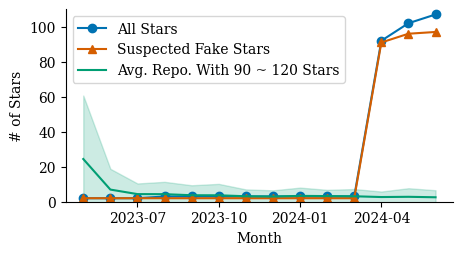

In [5]:
fig, ax = plt.subplots(figsize=(5, 2.5))
this_repo[["month", "n_stars"]].plot(
    x="month",
    color="C0",
    ax=ax,
    marker="o",
)
this_repo[["month", "n_stars_fake"]].plot(
    x="month",
    color="C2",
    ax=ax,
    marker="^",
)
sns.lineplot(
    x="timestep",
    y="n_stars",
    data=sample_repos[sample_repos.repo.isin(compare_repos) & (sample_repos.timestep <= 13)],
    color="C1",
    ax=ax,
    #marker="s",
    errorbar="sd"
)
# ax.set_title(f"Star History of {repo_name} ({int(this_repo["n_stars"].iloc[-1])} Stars)")
ax.set_ylabel("# of Stars")
ax.set_xlabel("Month")
ax.set_xticks(range(2, len(this_repo), 3))
ax.set_xticklabels(this_repo["month"].iloc[2::3])
ax.set_ylim(0, 110)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["All Stars", "Suspected Fake Stars", "Avg. Repo. With 90 ~ 120 Stars"])
fig.savefig("plots/example-timeline.pdf", bbox_inches="tight")

In [6]:
sample_actors = pd.read_csv(f"data/{END_DATE}/sample_actor_events.csv")
fake_actors = pd.read_csv(f"data/{END_DATE}/fake_actor_events.csv")

with pymongo.MongoClient(MONGO_URL) as client:
    fake_actor_ids = client.fake_stars.clustered_stars.find(
        {"repo": repo_name, "clustered": True}
    ).distinct("actor")

fake_actors = fake_actors[fake_actors.actor.isin(fake_actor_ids)].melt(
    id_vars=["actor"],
    value_vars=[x for x in fake_actors.columns if x.endswith("Event")],
    var_name="event",
    value_name="count",
)
sample_actors = sample_actors.melt(
    id_vars=["actor"],
    value_vars=[x for x in sample_actors.columns if x.endswith("Event")],
    var_name="event",
    value_name="count",
)

fake_actors["percentage"] = fake_actors["count"] / fake_actors.groupby("actor")[
    "count"
].transform("sum")
sample_actors["percentage"] = sample_actors["count"] / sample_actors.groupby("actor")[
    "count"
].transform("sum")

fake_actors["group"], sample_actors["group"] = "Suspected Fakes", "Random Stargazer"

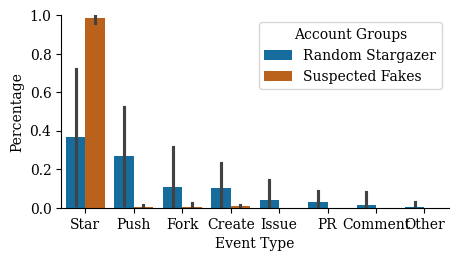

In [7]:
data = pd.concat([sample_actors, fake_actors])
data["event"] = data["event"].map(plot.shorten_gharchive_event)
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.barplot(
    x="event",
    y="percentage",
    data=data,
    hue="group",
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    errorbar="sd",
    ax=ax,
)
ax.set_ylabel("Percentage")
ax.set_xlabel("Event Type")
ax.legend(title="Account Groups")
ax.set_ylim(0, 1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#fig.autofmt_xdate()
fig.savefig("plots/example-events.pdf", bbox_inches="tight", dpi=300)